In [3]:
import random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import gymnasium as gym
import matplotlib.pyplot as plt

from torch.distributions import Normal
from tqdm import tqdm

In [4]:
class RolloutBuffer:
    def __init__(self):
        self.buffer = list()

    def store(self, transition):
        self.buffer.append(transition)

    def sample(self):
        s, a, r, s_prime, done = map(np.array, zip(*self.buffer))
        self.buffer.clear()
        return (
            torch.FloatTensor(s),
            torch.FloatTensor(a),
            torch.FloatTensor(r).unsqueeze(1),
            torch.FloatTensor(s_prime),
            torch.FloatTensor(done).unsqueeze(1)
        )

    @property
    def size(self):
        return len(self.buffer)


class MLPGaussianPolicy(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dims=(512, ), activation_fn=F.relu):
        super(MLPGaussianPolicy, self).__init__()
        self.input_layer = nn.Linear(state_dim, hidden_dims[0])
        self.hidden_layers = nn.ModuleList()
        for i in range(len(hidden_dims) - 1):
            hidden_layer = nn.Linear(hidden_dims[i], hidden_dims[i + 1])
            self.hidden_layers.append(hidden_layer)
        self.mu_layer = nn.Linear(hidden_dims[-1], action_dim)
        self.log_std_layer = nn.Linear(hidden_dims[-1], action_dim)
        self.activation_fn = activation_fn

    def forward(self, x):
        x = self.activation_fn(self.input_layer(x))
        for hidden_layer in self.hidden_layers:
            x = self.activation_fn(hidden_layer(x))

        mu = self.mu_layer(x)
        log_std = torch.tanh(self.log_std_layer(x))

        return mu, log_std.exp()


class MLPStateValue(nn.Module):
    def __init__(self, state_dim, hidden_dims=(512, ), activation_fn=F.relu):
        super(MLPStateValue, self).__init__()
        self.input_layer = nn.Linear(state_dim, hidden_dims[0])
        self.hidden_layers = nn.ModuleList()
        for i in range(len(hidden_dims) - 1):
            hidden_layer = nn.Linear(hidden_dims[i], hidden_dims[i + 1])
            self.hidden_layers.append(hidden_layer)
        self.output_layer = nn.Linear(hidden_dims[-1], 1)
        self.activation_fn = activation_fn

    def forward(self, x):
        x = self.activation_fn(self.input_layer(x))
        for hidden_layer in self.hidden_layers:
            x = self.activation_fn(hidden_layer(x))
        x = self.output_layer(x)

        return x

In [5]:
class TRPO:
    def __init__(
        self,
        state_dim,
        action_dim,
        hidden_dims=(64, 64),
        activation_fn=torch.tanh,
        batch_size=2048,
        value_lr=0.003,
        gamma=0.99,
        lmda=0.95,
        delta=0.01,
        num_value_updates=80,
        backtrack_iter=10,
        backtrack_coeff=1.0,
        backtrack_alpha=0.5
    ):
        self.gamma = gamma
        self.lmda = lmda
        self.delta = delta
        self.batch_size = batch_size
        self.num_value_updates = num_value_updates
        self.backtrack_iter = backtrack_iter
        self.backtrack_coeff = backtrack_coeff
        self.backtrack_alpha = backtrack_alpha

        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.policy = MLPGaussianPolicy(state_dim, action_dim, hidden_dims, activation_fn).to(self.device)
        self.old_policy = MLPGaussianPolicy(state_dim, action_dim, hidden_dims, activation_fn).to(self.device)
        self.value = MLPStateValue(state_dim, hidden_dims, activation_fn).to(self.device)  
        self.value_optimizer = torch.optim.Adam(self.value.parameters(), lr=value_lr)

        self.t = 0
        self.buffer = RolloutBuffer()

    @torch.no_grad()
    def act(self, s, training=True):
        self.policy.train(training)

        s = torch.as_tensor(s, dtype=torch.float, device=self.device)
        mu, std = self.policy(s)
        z = torch.normal(mu, std) if training else mu
        action = torch.tanh(z)

        return action.cpu().numpy()

    def flat_grad(self, grads, hessian=False):
        grad_flatten = []
        if not hessian:
            for grad in grads:
                grad_flatten.append(grad.view(-1))
            grad_flatten = torch.cat(grad_flatten)

        else:
            for grad in grads:
                grad_flatten.append(grad.contiguous().view(-1))
            grad_flatten = torch.cat(grad_flatten).data
        return grad_flatten

    def flat_params(self, model):
        params = []
        for param in model.parameters():
            params.append(param.data.view(-1))
        params_flatten = torch.cat(params)
        return params_flatten

    def update_model(self, model, new_params):
        index = 0
        for params in model.parameters():
            params_length = len(params.view(-1))
            new_param = new_params[index: index + params_length]
            new_param = new_param.view(params.size())
            params.data.copy_(new_param)
            index += params_length

    def gaussian_kl(self, state, old_policy, new_policy):
        mu_old, std_old = old_policy(state)
        mu_old, std_old = mu_old.detach(), std_old.detach()

        mu, std = new_policy(state)
        kl = torch.log(std / std_old) + (std_old.pow(2) + (mu_old - mu).pow(2)) / (2.0 * std.pow(2)) - 0.5
        return kl.sum(-1, keepdim=True).mean()
        
    def fisher_vector_product(self, state, p, damping_coeff=0.1):
        p.detach()
        kl = self.gaussian_kl(state, self.old_policy, self.policy)
        kl_grad = torch.autograd.grad(kl, self.policy.parameters(), create_graph=True)
        kl_grad = self.flat_grad(kl_grad)

        kl_grad_p = (kl_grad * p).sum()
        kl_hessian = torch.autograd.grad(kl_grad_p, self.policy.parameters())
        kl_hessian = self.flat_grad(kl_hessian, hessian=True)
        return kl_hessian + p * damping_coeff

    def conjugate_gradient(self, state, b, cg_iters=10, eps=1e-8, residual_tol=1e-10):
        x = torch.zeros_like(b)  # Initial guess x_0
        r = b.clone()  # r_0 = b - Ax_0 = b
        p = r.clone()  # p_0 = r_0

        rdotr = torch.dot(r, r)
        for _ in range(cg_iters):
            Ap = self.fisher_vector_product(state, p)
            alpha = rdotr / (torch.dot(p, Ap) + eps)

            x += alpha * p
            r -= alpha * Ap

            new_rdotr = torch.dot(r, r)
            beta = new_rdotr / rdotr
            p = r + beta * p

            rdotr = new_rdotr
            if rdotr < residual_tol:
                break
        return x

    def learn(self):
        self.policy.train()
        self.value.train()

        s, a, r, s_prime, done = self.buffer.sample()
        s, a, r, s_prime, done = map(lambda x: x.to(self.device), [s, a, r, s_prime, done])

        with torch.no_grad():
            delta = r + (1 - done) * self.gamma * self.value(s_prime) - self.value(s)
            ret = torch.clone(r)
            adv = torch.clone(delta)
            for t in reversed(range(len(ret) - 1)):
                ret[t] += (1 - done[t]) * self.gamma * ret[t + 1]
                adv[t] += (1 - done[t]) * self.gamma * self.lmda * adv[t + 1]

        for _ in range(self.num_value_updates):
            value = self.value(s)
            value_loss = F.mse_loss(value, ret)
            self.value_optimizer.zero_grad()
            value_loss.backward()
            self.value_optimizer.step()

        with torch.no_grad():
            mu, std = self.policy(s)
            m = Normal(mu, std)
            z = torch.atanh(torch.clamp(a, -1.0 + 1e-7, 1.0 - 1e-7))
            log_prob_old = m.log_prob(z).sum(dim=-1, keepdim=True)

        mu, std = self.policy(s)
        m = Normal(mu, std)
        z = torch.atanh(torch.clamp(a, -1.0 + 1e-7, 1.0 - 1e-7))
        log_prob = m.log_prob(z).sum(dim=-1, keepdim=True)

        ratio_old = (log_prob - log_prob_old).exp()
        policy_loss_old = (ratio_old * adv).mean()

        gradient = torch.autograd.grad(policy_loss_old, self.policy.parameters())
        gradient = self.flat_grad(gradient)

        search_dir = self.conjugate_gradient(s, gradient.data)
        gHg = (self.fisher_vector_product(s, search_dir) * search_dir).sum(0)
        gHg = -gHg if gHg < 0 else gHg
        step_size = torch.sqrt(2 * self.delta / gHg)
        old_params = self.flat_params(self.policy)
        self.update_model(self.old_policy, old_params)

        # Backtrack line search
        with torch.no_grad():
            expected_improve = (gradient * step_size * search_dir).sum(0, keepdim=True)
            for i in range(self.backtrack_iter):
                params = old_params + self.backtrack_coeff * step_size * search_dir
                self.update_model(self.policy, params)

                mu, std = self.policy(s)
                m = Normal(mu, std)
                z = torch.atanh(torch.clamp(a, -1.0 + 1e-7, 1.0 - 1e-7))
                log_prob = m.log_prob(z).sum(dim=-1, keepdim=True)
                ratio = (log_prob - log_prob_old).exp()
                policy_loss = (ratio * adv).mean()

                loss_improve = policy_loss - policy_loss_old
                expected_improve *= self.backtrack_coeff
                improve_condition = loss_improve / expected_improve

                kl = self.gaussian_kl(s, self.old_policy, self.policy)

                if kl < self.delta and improve_condition > self.backtrack_alpha:
                    break

                if i == self.backtrack_iter - 1:
                    params = self.flat_params(self.old_policy)
                    self.update_model(self.policy, params)
                self.backtrack_coeff *= 0.5

        result = {
            'Step': self.t,
            'policy_loss': policy_loss.item(),
            'value_loss': value_loss.item(),
        }

        return result

    def step(self, transition):
        result = None
        self.t += 1
        self.buffer.store(transition)
        if self.buffer.size >= self.batch_size:
            result = self.learn()

        return result

In [6]:
def evaluate(env_name, agent, seed, eval_iterations):
    env = gym.make(env_name)
    scores = []
    for i in range(eval_iterations):
        (s, _), terminated, truncated, score = env.reset(seed=seed + 100 + i), False, False, 0
        while not (terminated or truncated):
            a = agent.act(s, training=False)
            s_prime, r, terminated, truncated, _ = env.step(2.0 * a)
            score += r
            s = s_prime
        scores.append(score)
    env.close()
    return round(np.mean(scores), 4)

In [7]:
def seed_all(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

In [8]:
env_name = 'Pendulum-v1'

seed = 0
seed_all(seed)
hidden_dims = (64, 64, )
max_iterations = 1000000
eval_intervals = 10000
eval_iterations = 10
batch_size = 2000
activation_fn = torch.tanh
gamma = 0.95
lmda = 0.95
backtrack_alpha = 0.5

env = gym.make(env_name)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
agent = TRPO(
    state_dim,
    action_dim,
    hidden_dims=hidden_dims,
    activation_fn=activation_fn,
    batch_size=batch_size,
    gamma=gamma,
    lmda=lmda,
    backtrack_alpha=backtrack_alpha,
)

logger = []
(s, _), terminated, truncated = env.reset(seed=seed), False, False
for t in tqdm(range(1, max_iterations + 1)):
    a = agent.act(s)
    s_prime, r, terminated, truncated, _ = env.step(2.0 * a)
    result = agent.step((s, a, r, s_prime, terminated))
    s = s_prime
    
    if result is not None:
        logger.append([t, 'policy_loss', result['policy_loss']])
        logger.append([t, 'value_loss', result['value_loss']])
    
    if terminated or truncated:
        (s, _), terminated, truncated = env.reset(), False, False
        
    if t % eval_intervals == 0:
        score = evaluate(env_name, agent, seed, eval_iterations)
        logger.append([t, 'Avg return', score])

100%|██████████████████████████████████████████████████████████████████████| 1000000/1000000 [12:00<00:00, 1388.64it/s]


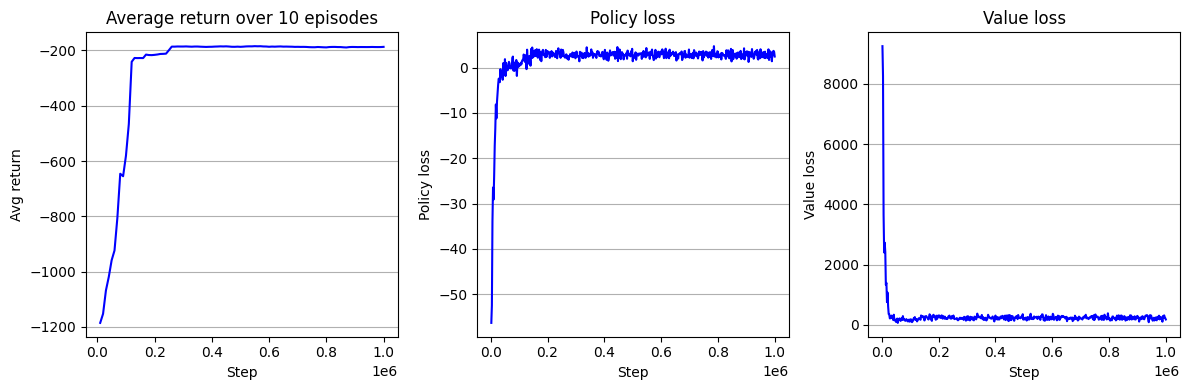

In [9]:
logger = pd.DataFrame(logger)
logger.columns = ['step', 'key', 'value']

fig = plt.figure(figsize=(12, 4))

ax = fig.add_subplot(1, 3, 1)
key = 'Avg return'
ax.plot(logger.loc[logger['key'] == key, 'step'], logger.loc[logger['key'] == key, 'value'], 'b-')
ax.grid(axis='y')
ax.set_title("Average return over 10 episodes")
ax.set_xlabel("Step")

ax.set_ylabel("Avg return")

ax = fig.add_subplot(1, 3, 2)
key = 'policy_loss'
ax.plot(logger.loc[logger['key'] == key, 'step'], logger.loc[logger['key'] == key, 'value'], 'b-')
ax.grid(axis='y')
ax.set_title("Policy loss")
ax.set_xlabel("Step")
ax.set_ylabel("Policy loss")

ax = fig.add_subplot(1, 3, 3)
key = 'value_loss'
ax.plot(logger.loc[logger['key'] == key, 'step'], logger.loc[logger['key'] == key, 'value'], 'b-')
ax.grid(axis='y')
ax.set_title("Value loss")
ax.set_xlabel("Step")
ax.set_ylabel("Value loss")

fig.tight_layout()
plt.show()